In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold


# Load the data
# Load the data with ';' delimiter
measures = pd.read_csv('measures.csv', delimiter=';')
to_predict = pd.read_csv('to_predict.csv', delimiter=';')

# Convert comma decimal separator to dot and convert columns to appropriate types
measures = measures.map(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
measures = measures.astype({col: float for col in measures.columns if col not in ['subject', 'activity']})
measures['subject'] = measures['subject'].astype(float)

to_predict = to_predict.map(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
to_predict = to_predict.astype({col: float for col in measures.columns if col not in ['subject', 'activity']})


# Select only the columns that include "entropy" and the "subject" and "activity" columns
#columns_to_use = [col for col in measures.columns if 'entropy' in col] + ['subject', 'activity']
#measures_filtered = measures[columns_to_use]
#to_predict_filtered = to_predict[[col for col in to_predict.columns if 'entropy' in col] + ['subject']]

# Define the subjects for training and test sets
training_subjects = [1, 3, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
test_subjects = [27, 28, 29, 30]

# Split the measures dataset into training and test sets
training_set = measures[measures['subject'].isin(training_subjects)]
test_set = measures[measures['subject'].isin(test_subjects)]

# Ensure there's no overlap
assert not training_set['subject'].isin(test_subjects).any(), "Training and test sets overlap!"

# Define features and labels
X_train = training_set.drop(columns=['subject', 'activity'])
y_train = training_set['activity']

X_test = test_set.drop(columns=['subject', 'activity'])
y_test = test_set['activity']


print("finished prep")

finished prep


In [13]:
from sklearn.feature_selection import VarianceThreshold

# Initialize a variance threshold selector
variance_threshold = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed

# Apply the selector to the training data
X_train_var = variance_threshold.fit_transform(X_train)
X_test_var = variance_threshold.transform(X_test)

# Get the column names that pass the variance threshold
selected_columns_var = X_train.columns[variance_threshold.get_support()]

# Convert back to DataFrame
X_train_var = pd.DataFrame(X_train_var, columns=selected_columns_var)
X_test_var = pd.DataFrame(X_test_var, columns=selected_columns_var)


In [14]:
# Calculate correlation matrix
corr_matrix = X_train_var.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop the highly correlated features
X_train_uncorr = X_train_var.drop(columns=to_drop)
X_test_uncorr = X_test_var.drop(columns=to_drop)


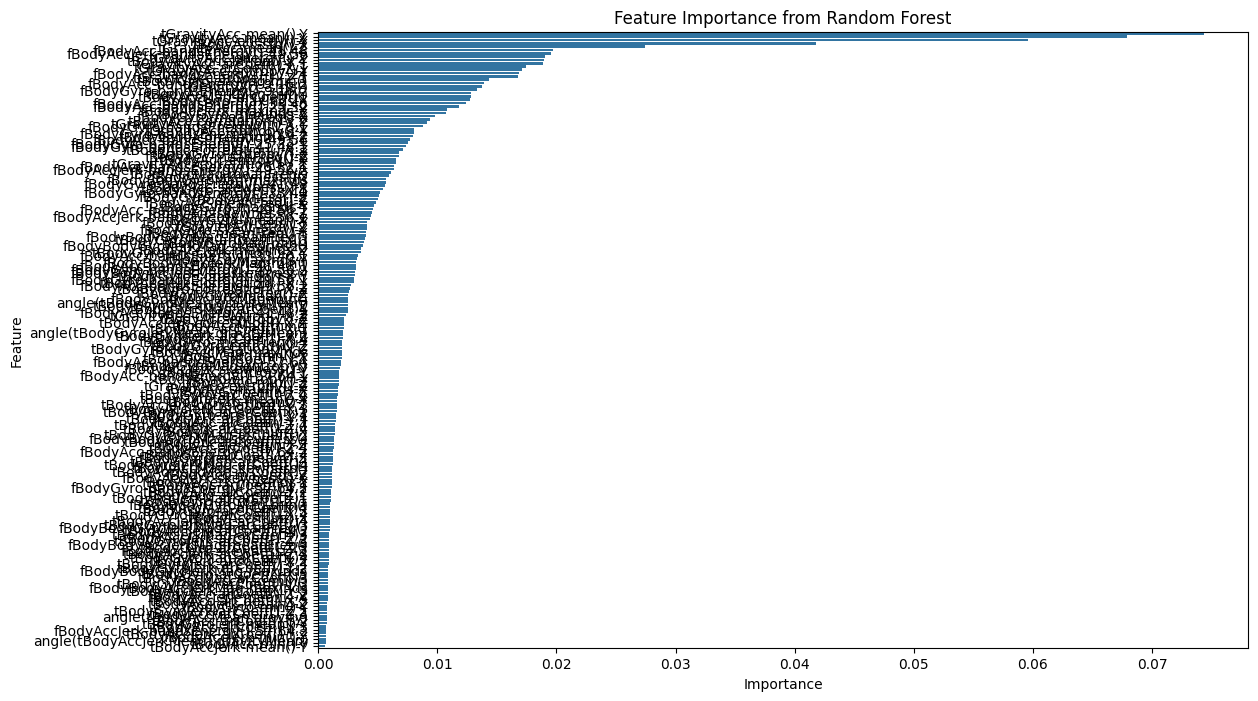

In [15]:
# Train a Random Forest model to get feature importances
rf_model = RandomForestClassifier(max_depth=20, n_estimators=200)
rf_model.fit(X_train_uncorr, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = X_train_uncorr.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

# Define a threshold for feature importance
importance_threshold = 0.01

# Filter features based on importance
important_features = importance_df[importance_df['Importance'] > importance_threshold]['Feature']
X_train_important = X_train_uncorr[important_features]
X_test_important = X_test_uncorr[important_features]





In [18]:
# Initialize classifiers with chosen hyperparameters
log_reg = LogisticRegression(max_iter=10000, C=38, dual=False)
svm = SVC(C=40, gamma=0.055, kernel='rbf', probability=True)
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
dt = DecisionTreeClassifier(max_depth=100, min_samples_split=2)
rf = RandomForestClassifier(max_depth=100, n_estimators=1000)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
nb = GaussianNB()
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1, algorithm="SAMME")
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', alpha=0.002, learning_rate='adaptive', max_iter=2500)
xgb = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=5, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss')

# Define the ensemble of classifiers
ensemble = VotingClassifier(estimators=[
    ('log_reg', log_reg),
    ('svm', svm),
    #('knn', knn),
    #('dt', dt),
    #('rf', rf),
    #('gb', gb),
    #('nb', nb),
    #('ada', ada),
    #('mlp', mlp),
    #('xgb', xgb)
], voting='soft')  # Use 'soft' for probability-based voting

# Fit the ensemble model
ensemble.fit(X_train_important, y_train)


print("-->", ensemble.score(X_train_important, y_test))

# Predict on the test set
y_pred = ensemble.predict(X_test_important)

# Calculate accuracy and classification error
accuracy = accuracy_score(y_test, y_pred)
classification_error = 1 - accuracy

# Print the results
print("\nEnsemble Model:")
print("Test Set Accuracy:", accuracy)

#subject 1 bis 16 in training
# run one Test Set Accuracy:    0.9602693602693603
# nur logReg Test Set Accuracy: 0.9629629629629629
# nur svm Test Set Accuracy:    0.9622895622895623
# LR und SVM Test Set Accuracy: 0.9663299663299664 !!!
# xgb Test Set Accuracy:        0.9488215488215488
# xbg lr svm Test Set Accuracy: 0.9643097643097643


# xgb optimize Test Set Accuracy:       0.9434343434343434
# 0.2 learning rate Test Set Accuracy:  0.9474747474747475
# 0.5 Test Set Accuracy:                0.9420875420875421

#mlp optimize Test Set Accuracy:              0.938047138047138
# solver a -> lb Test Set Accuracy:           0.958922558922559
# activision logitic <- al Test Set Accuracy: 0.9501683501683502
# alpha von 001 auf .002 Test Set Accuracy:   0.9616161616161616

# svm lr mlp noch nicht besser Test Set Accuracy: 0.9602693602693603
# opti rf 50 1000 --> 0.9643097643097643
# rf 100 1000 --> --> 0.9649831649831649
 
# training mit allen 
# lr svm Test Set Accuracy: 0.9717171717171718

ValueError: Found input variables with inconsistent numbers of samples: [1485, 5867]

In [ ]:

# Prepare the to_predict features, ensuring to match the training features
#to_predict_features = to_predict_filtered[X_train.columns]

# Predict activities in to_predict.csv
#predicted_activities = ensemble.predict(to_predict_features)

# Add predictions to the to_predict DataFrame
#to_predict_filtered['predicted_activity'] = predicted_activities

# Display the first few rows with predictions
#print("\nPredictions on to_predict.csv:")
#print(to_predict_filtered.head())